<a href="https://colab.research.google.com/github/zalfa19/Analisa-Sentimen-Kota-Surabaya-2024/blob/main/Analisa_Sentimen_Kota_Surabaya_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Library Sastrawi dan NLTK**

Karena tidak terinstall secara default pada environment Google Collab

In [ ]:
!pip install sastrawi nltk

## **Import Library Yang Dibutuhkan**

In [ ]:
import pandas as pd
import re
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

## **Import Data**

In [ ]:
event_df_1 = pd.read_csv('/content/drive/MyDrive/zett/2025/01. Januari/250104 - Sentimen Instagram/Instagram Comments/Event/Event_instagram_comments.csv')
event_df_2 = pd.read_csv('/content/drive/MyDrive/zett/2025/01. Januari/250104 - Sentimen Instagram/Instagram Comments/Event/Event_instagram_comments2.csv')

program_df_1 = pd.read_csv('/content/drive/MyDrive/zett/2025/01. Januari/250104 - Sentimen Instagram/Instagram Comments/Program/Program.csv', encoding='latin-1') # or 'cp1252'
program_df_2 = pd.read_csv('/content/drive/MyDrive/zett/2025/01. Januari/250104 - Sentimen Instagram/Instagram Comments/Program/Program2.csv', encoding='latin-1') # or 'cp1252'

fasilitas_df_1 = pd.read_csv('/content/drive/MyDrive/zett/2025/01. Januari/250104 - Sentimen Instagram/Instagram Comments/Fasilitas/Fasilitas_instagram_comments.csv', encoding='latin-1') # or 'cp1252'
fasilitas_df_2 = pd.read_csv('/content/drive/MyDrive/zett/2025/01. Januari/250104 - Sentimen Instagram/Instagram Comments/Fasilitas/Fasilitas_instagram_comments2.csv', encoding='latin-1') # or 'cp1252'

layanan_df_1 = pd.read_csv('/content/drive/MyDrive/zett/2025/01. Januari/250104 - Sentimen Instagram/Instagram Comments/Layanan/Layanan_instagram_comments.csv') # or 'cp1252'
layanan_df_2 = pd.read_csv('/content/drive/MyDrive/zett/2025/01. Januari/250104 - Sentimen Instagram/Instagram Comments/Layanan/Layanan_Instagram_comments2.csv') # or 'cp1252'

## **Function Utk Preprocessing Teks**

In [ ]:
# Fungsi preprocessing
def bersihkan_teks(teks):
    """Membersihkan teks dari spam, teks non-Indonesia, dan komentar tidak lengkap."""
    if not isinstance(teks, str) or len(teks.split()) < 3 or not re.search(r'[a-zA-Z]', teks):
        return None
    return teks

def tokenisasi_dan_filter(teks, stopwords_indonesia):
    """Melakukan tokenisasi dan menghapus kata berhenti (stopwords)."""
    tokens = teks.split()
    tokens_tersaring = [token for token in tokens if token not in stopwords_indonesia]
    return tokens, tokens_tersaring

def lemmatize_tokens(tokens, stemmer):
    """Melakukan stemming menggunakan Sastrawi stemmer."""
    lemmatized_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

## **Menggunakan Pretrained IndoBERT Untuk Klasifikasi Sentimen**

In [ ]:
# Inisialisasi pipeline analisis sentimen
sentiment_pipeline = pipeline('sentiment-analysis', model='mdhugol/indonesia-bert-sentiment-classification')

# Inisialisasi stemmer Sastrawi dan daftar stopwords bahasa Indonesia
import nltk
nltk.download('stopwords')

stemmer = StemmerFactory().create_stemmer()
stopwords_indonesia = set(stopwords.words('indonesian'))

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mapping Label Sentiment

In [ ]:
# Mapping label sentiment
label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

## **Function Utk Menyatukan Function Preprocessing**

In [ ]:
def preprocessing_data(df):
    """Melakukan semua langkah preprocessing dan menggabungkan hasilnya dalam satu output."""
    df['cleaned_comment'] = df['Komentar'].apply(bersihkan_teks)
    df.dropna(subset=['cleaned_comment'], inplace=True)

    df[['tokens', 'filtered_tokens']] = df['cleaned_comment'].str.lower().apply(
        lambda x: pd.Series(tokenisasi_dan_filter(x, stopwords_indonesia))
    )

    df['lemmatized_comment'] = df['filtered_tokens'].apply(lambda tokens: lemmatize_tokens(tokens, stemmer))

    df['sentiment_raw'] = df['lemmatized_comment'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
    df['sentiment'] = df['sentiment_raw'].map(label_index)

    return df

## **Function Utk Visualisasi Data**

In [ ]:
def visualisasi_data(df, name):
    """Membuat visualisasi hasil sentimen."""
    sentiment_counts = df['sentiment'].value_counts()

    # Tabel distribusi sentimen
    sentiment_table = pd.DataFrame({'Sentimen': sentiment_counts.index, 'Jumlah': sentiment_counts.values})
    print(f"Tabel Distribusi Sentimen - {name}")
    print(sentiment_table)
    print("\n")

    # Diagram pie distribusi sentimen
    plt.figure(figsize=(6, 6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribusi Sentimen - {name}')
    plt.show()
    print("\n")

    # Diagram batang distribusi sentimen
    plt.figure(figsize=(8, 6))
    sentiment_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
    plt.title(f'Distribusi Sentimen - {name}')
    plt.xlabel('Sentimen')
    plt.ylabel('Frekuensi')
    plt.show()
    print("\n")

    # Wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['lemmatized_comment']))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud - {name}')
    plt.show()

## **Mengaplikasikan Function Yang Sudah Dibuat Pada Setiap Aspek**

### **Aspek Event 1**

In [ ]:
# Memproses data event_df_1
print("=== Memproses Data: event_df_1 ===")
event_df_1_processed = preprocessing_data(event_df_1)
event_df_1_processed

=== Memproses Data: event_df_1 ===


,Username,Waktu,Komentar,cleaned_comment,tokens,filtered_tokens,lemmatized_comment,sentiment_raw,sentiment
0,surabaya,32w,WELCOME TO THE CHRONICLE OF SURABAYA 🤩🤩 Surab...,WELCOME TO THE CHRONICLE OF SURABAYA 🤩🤩 Surab...,"[welcome, to, the, chronicle, of, surabaya, 🤩🤩...","[welcome, to, the, chronicle, of, surabaya, 🤩🤩...",welcome to the chronicle of surabaya surabaya...,LABEL_1,neutral
1,nayah,32w,Bagus semua🔥🔥🔥 gudang garam megah polll🔥 arina...,Bagus semua🔥🔥🔥 gudang garam megah polll🔥 arina...,"[bagus, semua🔥🔥🔥, gudang, garam, megah, polll🔥...","[bagus, semua🔥🔥🔥, gudang, garam, megah, polll🔥...",bagus semua gudang garam megah polll arinazfty s,LABEL_0,positive
2,arinazfty,32w,@nina.nayah trimakasih🥰 kulasongo_'s,@nina.nayah trimakasih🥰 kulasongo_'s,"[@nina.nayah, trimakasih🥰, kulasongo_'s]","[@nina.nayah, trimakasih🥰, kulasongo_'s]",nina nayah trimakasih kulasongo s,LABEL_1,neutral
3,kulasongo_,32w,"@nina.nayah pas liat di live keren kostumnya, ...","@nina.nayah pas liat di live keren kostumnya, ...","[@nina.nayah, pas, liat, di, live, keren, kost...","[@nina.nayah, pas, liat, live, keren, kostumny...",nina nayah pas liat live keren kostum nyempet2...,LABEL_0,positive
4,leapsurabaya,32w,asliii kereen polll😍🔥 hendra_dimas87's,asliii kereen polll😍🔥 hendra_dimas87's,"[asliii, kereen, polll😍🔥, hendra_dimas87's]","[asliii, kereen, polll😍🔥, hendra_dimas87's]",asliii kereen polll hendra dimas87 s,LABEL_0,positive
6,yunia1716,32w,Rela panas2an ...🔥🔥#surabayakerenn😎 maulanahan...,Rela panas2an ...🔥🔥#surabayakerenn😎 maulanahan...,"[rela, panas2an, ...🔥🔥#surabayakerenn😎, maulan...","[rela, panas2an, ...🔥🔥#surabayakerenn😎, maulan...",rela panas2an surabayakerenn maulanahanifibrah...,LABEL_1,neutral
9,momyaldira,32w,Hooo....hooo..hooo...hooo...Gudang garam jaya....,Hooo....hooo..hooo...hooo...Gudang garam jaya....,"[hooo....hooo..hooo...hooo...gudang, garam, ja...","[hooo....hooo..hooo...hooo...gudang, garam, ja...",hooo hooo hooo hooo gudang garam jaya ayeeeeee...,LABEL_0,positive
10,arsiesha,32w,🔥🔥🔥nggak sempat liat😢 bonvoyage.genu's bonvoy...,🔥🔥🔥nggak sempat liat😢 bonvoyage.genu's bonvoy...,"[🔥🔥🔥nggak, sempat, liat😢, bonvoyage.genu's, bo...","[🔥🔥🔥nggak, liat😢, bonvoyage.genu's, bonvoyage.]",nggak liat bonvoyage genu s bonvoyage,LABEL_2,negative
11,genu,32w,benefit apa yang didapat oleh peserta yang men...,benefit apa yang didapat oleh peserta yang men...,"[benefit, apa, yang, didapat, oleh, peserta, y...","[benefit, peserta, mengikuti, festival, ?, afr...",benefit serta ikut festival afriaaaan s,LABEL_1,neutral
12,afriaaaan,32w,hbd jua.26.01's jua.26.,hbd jua.26.01's jua.26.,"[hbd, jua.26.01's, jua.26.]","[hbd, jua.26.01's, jua.26.]",hbd jua 26 01 s jua 26,LABEL_1,neutral


Dataframe di atas, menunjukan hasil preprocessing teks hingga klasifikasi sentimen yang diperlukan, mulai dari tahapan cleaning lemmitization teks dan diakhiri dengan klasifikasi sentimen dari setiap komentarnya. Komentar beragam bermunculan pada aspek event ini, mulai dari masyarakat yang antusias mengenai program ini hingga berbagai macam dukungan terhadap acara ini.

Tabel Distribusi Sentimen - event_df_1
   Sentimen  Jumlah
0   neutral      12
1  positive       7
2  negative       5




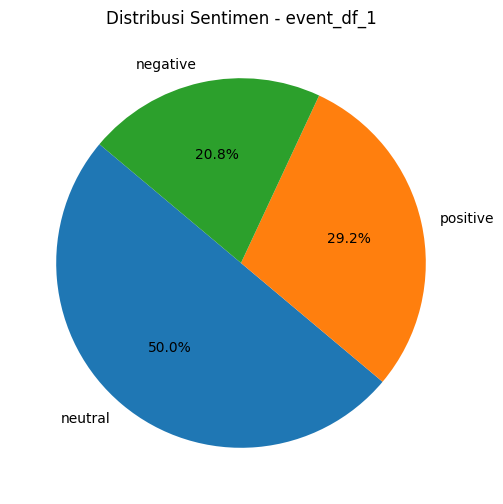

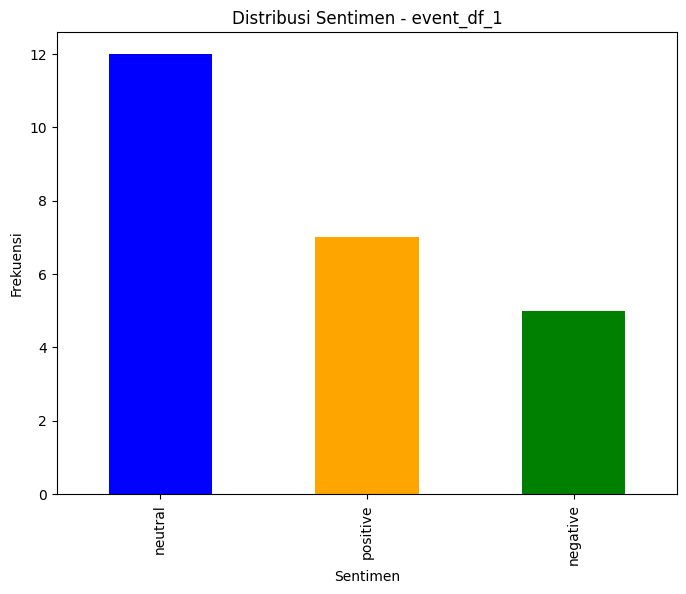

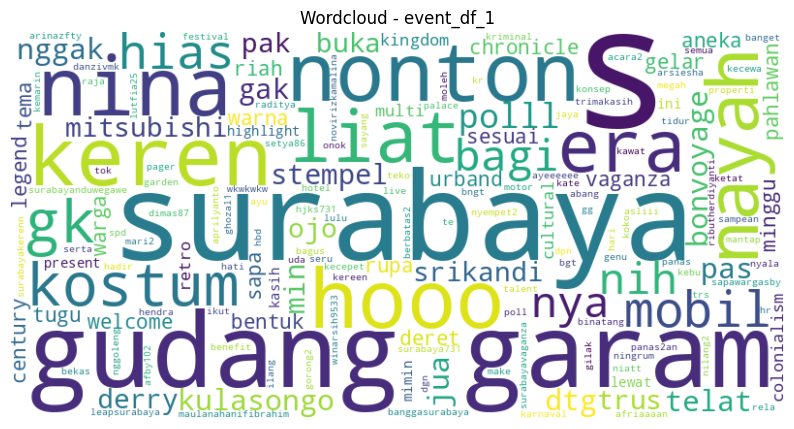

In [ ]:
event_df_1_processed.to_excel('event_df_1_processed.xlsx', index=False)
visualisasi_data(event_df_1_processed, 'event_df_1')

Hasil visualisasi dari bar chart dan pie chart menunjukan bahwa 50% komentar bersentimen netral, yang artinya bahwa event yang dilaksanakan pemerintah cenderung biasa saja, banyak warga masyarakat yang antara setuju dan tidak setuju dengan fasilitas yang disediakan, disamping itu, sentimen positif memiliki proporsi yang lebih banyak dibandingkan dengan proporsi sentimen negatif.


Lalu, dari hasil wordcloud, kata yang paling sering muncul adalah surabaya yang merupakan kota yang diambil sebagai subjek penelitian, lalu beberapa kata seperti nonton, keren, nina, gudang garam, mobil, kotsum yang sepertinya masyarakat sangat antusias terhadap event ini.

### **Aspek Event 2**

In [ ]:
# Memproses data event_df_2
print("=== Memproses Data: event_df_2 ===")
event_df_2_processed = preprocessing_data(event_df_2)
event_df_2_processed

=== Memproses Data: event_df_2 ===


,Username,Waktu,Komentar,cleaned_comment,tokens,filtered_tokens,lemmatized_comment,sentiment_raw,sentiment
0,abiyyu_rpw,3w,Apakah sudah ada jadwal jam? idafarida4890's,Apakah sudah ada jadwal jam? idafarida4890's,"[apakah, sudah, ada, jadwal, jam?, idafarida48...","[jadwal, jam?, idafarida4890's]",jadwal jam idafarida4890 s,LABEL_1,neutral
1,idafarida4890,3w,Jam berapa ya ? Tks fisioterapisurabaya's,Jam berapa ya ? Tks fisioterapisurabaya's,"[jam, berapa, ya, ?, tks, fisioterapisurabaya's]","[jam, ya, ?, tks, fisioterapisurabaya's]",jam ya tks fisioterapisurabaya s,LABEL_1,neutral
2,fisioterapisurabaya,3w,Waw! 😆 scoliosis_surabaya's,Waw! 😆 scoliosis_surabaya's,"[waw!, 😆, scoliosis_surabaya's]","[waw!, 😆, scoliosis_surabaya's]",waw scoliosis surabaya s,LABEL_1,neutral
3,scoliosis_surabaya,3w,Kereen! 🤩 ms.riri_cute's ms.,Kereen! 🤩 ms.riri_cute's ms.,"[kereen!, 🤩, ms.riri_cute's, ms.]","[kereen!, 🤩, ms.riri_cute's, ms.]",kereen ms riri cute s ms,LABEL_0,positive
4,riri_cute,3w,Pakk.. Tolong ad anak kcl 4tj d cubit belasan ...,Pakk.. Tolong ad anak kcl 4tj d cubit belasan ...,"[pakk.., tolong, ad, anak, kcl, 4tj, d, cubit,...","[pakk.., tolong, ad, anak, kcl, 4tj, d, cubit,...",pakk tolong ad anak kcl 4tj d cubit bas kali s...,LABEL_2,negative
5,tiarraputri_69,3w,Ada anak kecil di cubit gak berenti2 sama bapa...,Ada anak kecil di cubit gak berenti2 sama bapa...,"[ada, anak, kecil, di, cubit, gak, berenti2, s...","[anak, cubit, gak, berenti2, bapak2, infonya, ...",anak cubit gak berenti2 bapak2 info surabaya t...,LABEL_1,neutral


Dataframe di atas, menunjukan hasil preprocessing teks hingga klasifikasi sentimen yang diperlukan, mulai dari tahapan cleaning lemmitization teks dan diakhiri dengan klasifikasi sentimen dari setiap komentarnya. Komentar beragam bermunculan pada aspek event ini, mulai dari masyarakat yang bertanya mengenai dimulainya acara, dan mengapresisasi acara tersebut.

Tabel Distribusi Sentimen - event_df_2
   Sentimen  Jumlah
0   neutral       4
1  positive       1
2  negative       1




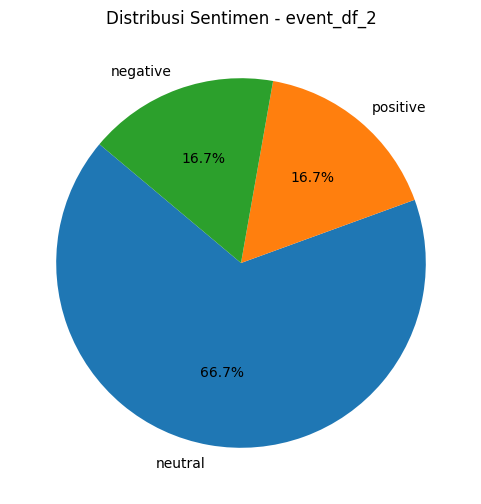

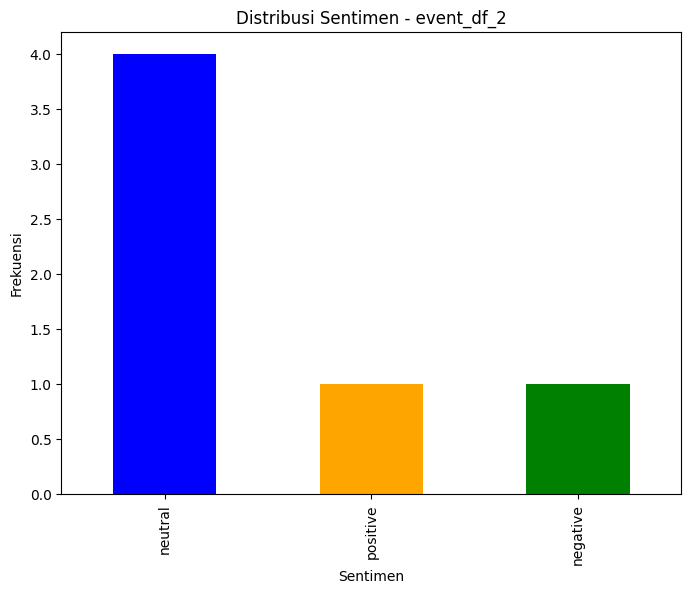

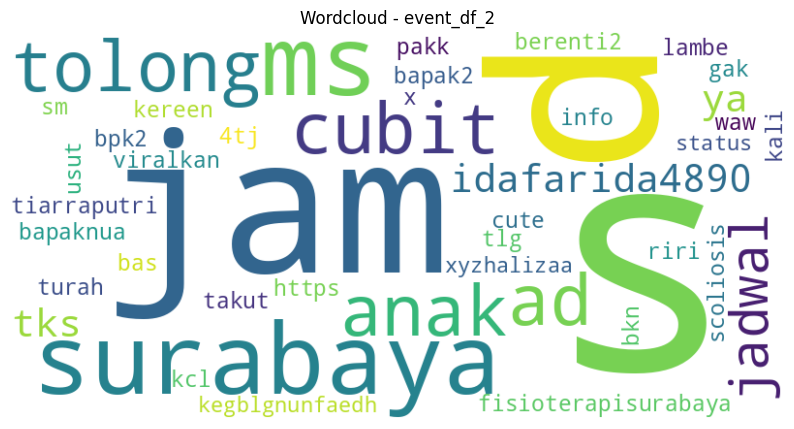

In [ ]:
event_df_2_processed.to_excel('event_df_2_processed.xlsx', index=False)
visualisasi_data(event_df_2_processed, 'event_df_2')

Hasil visualisasi dari bar chart dan pie chart menunjukan bahwa 67% komentar bersentimen netral, yang artinya bahwa event yang dilaksanakan pemerintah cenderung biasa saja, banyak warga masyarakat yang antara setuju dan tidak setuju dengan fasilitas yang disediakan, disamping itu, sentimen positif memiliki proporsi yang lebih banyak dibandingkan dengan proporsi sentimen negatif.


Lalu, dari hasil wordcloud, kata yang paling sering muncul adalah jam yang menandakan masyarakat menanyakan mengenai dimulainya acara ini, lalu surabaya yang merupakan kota dilaksanakannya event ini.

### **Aspek Fasilitas 1**

In [ ]:
# Memproses data fasilitas_df_1
print("=== Memproses Data: fasilitas_df_1 ===")
fasilitas_df_1_processed = preprocessing_data(fasilitas_df_1)
fasilitas_df_1_processed

=== Memproses Data: fasilitas_df_1 ===


,Username,Waktu,Komentar,cleaned_comment,tokens,filtered_tokens,lemmatized_comment,sentiment_raw,sentiment
0,surabaya,14w,Hari baik untuk Surabaya makin apik! ð Sur...,Hari baik untuk Surabaya makin apik! ð Sur...,"[hari, baik, untuk, surabaya, makin, apik!, ð...","[surabaya, apik!, ð, suroboyo, bus, resmi, ...",surabaya apik suroboyo bus resmi tambah armad...,LABEL_0,positive
1,tfsurabaya,14w,Semangat terus! Terimakasih transportasi umum ...,Semangat terus! Terimakasih transportasi umum ...,"[semangat, terus!, terimakasih, transportasi, ...","[semangat, terus!, terimakasih, transportasi, ...",semangat terus terimakasih transportasi suraba...,LABEL_0,positive
2,rg,14w,@tfsurabaya up up upð¥ð¥ jacksparrow_is_me's,@tfsurabaya up up upð¥ð¥ jacksparrow_is_me's,"[@tfsurabaya, up, up, upð¥ð¥, jacksparrow_...","[@tfsurabaya, up, up, upð¥ð¥, jacksparrow_...",tfsurabaya up up up jacksparrow is me s,LABEL_1,neutral
3,jacksparrow_is_me,14w,@tfsurabaya susah e nang indo iki B2B. Mesti i...,@tfsurabaya susah e nang indo iki B2B. Mesti i...,"[@tfsurabaya, susah, e, nang, indo, iki, b2b.,...","[@tfsurabaya, susah, e, nang, indo, iki, b2b.,...",tfsurabaya susah e nang indo iki b2b mesti inv...,LABEL_2,negative
4,iaridlo,14w,@tfsurabaya awakmu gak tahu diajak ngobrol ta ...,@tfsurabaya awakmu gak tahu diajak ngobrol ta ...,"[@tfsurabaya, awakmu, gak, tahu, diajak, ngobr...","[@tfsurabaya, awakmu, gak, diajak, ngobrol, ta...",tfsurabaya awak gak ajak ngobrol ta min saknon...,LABEL_1,neutral
...,...,...,...,...,...,...,...,...,...
69,dimasadityapratama_,14w,Kudu e ws nduwe jalur khusus untuk angkutan um...,Kudu e ws nduwe jalur khusus untuk angkutan um...,"[kudu, e, ws, nduwe, jalur, khusus, untuk, ang...","[kudu, e, ws, nduwe, jalur, khusus, angkutan, ...",kudu e ws nduwe jalur khusus angkut umum cek g...,LABEL_1,neutral
70,dimasariefhadianto_,13w,Surabaya itu Kota Metropolitan No 1 bukan No 2...,Surabaya itu Kota Metropolitan No 1 bukan No 2...,"[surabaya, itu, kota, metropolitan, no, 1, buk...","[surabaya, kota, metropolitan, no, 1, no, 2......",surabaya kota metropolitan no 1 no 2 yg maksud...,LABEL_1,neutral
71,yahyahasan538,13w,Menurut sy Surabaya adalah kota2 yg masih sang...,Menurut sy Surabaya adalah kota2 yg masih sang...,"[menurut, sy, surabaya, adalah, kota2, yg, mas...","[sy, surabaya, kota2, yg, sangat2, ketinggalan...",sy surabaya kota2 yg sangat2 tinggal dgn kota ...,LABEL_0,positive
72,yerichaa,13w,Jurusan T1-T2 Juanda plissssssð¥ð¥ð¥ð¥...,Jurusan T1-T2 Juanda plissssssð¥ð¥ð¥ð¥...,"[jurusan, t1-t2, juanda, plissssssð¥ð¥ð¥...","[jurusan, t1-t2, juanda, plissssssð¥ð¥ð¥...",jurus t1-t2 juanda plissssss lianherlian s,LABEL_0,positive


Dataframe di atas, menunjukan hasil preprocessing teks hingga klasifikasi sentimen yang diperlukan, mulai dari tahapan cleaning lemmitization teks dan diakhiri dengan klasifikasi sentimen dari setiap komentarnya. Komentar beragam bermunculan pada aspek fasilitas ini, mulai dari masyarakat yang mengapresiasi kinerja pemerintah untuk memberikan fasilitas transportasi umum dan lainnya.

Tabel Distribusi Sentimen - fasilitas_df_1
   Sentimen  Jumlah
0   neutral      53
1  negative      11
2  positive       8




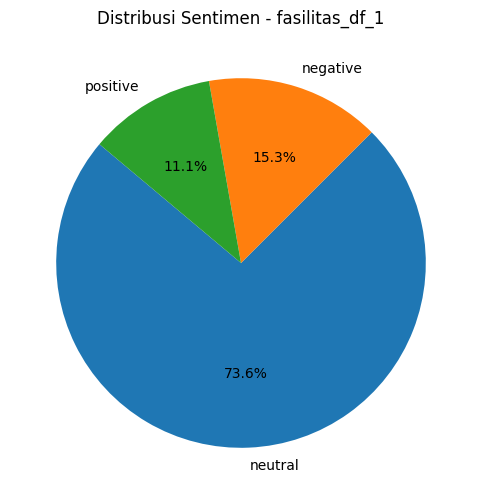

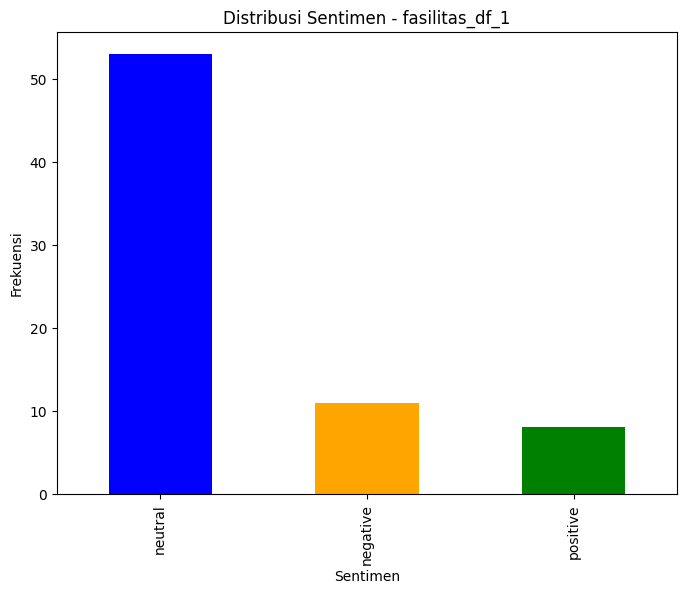

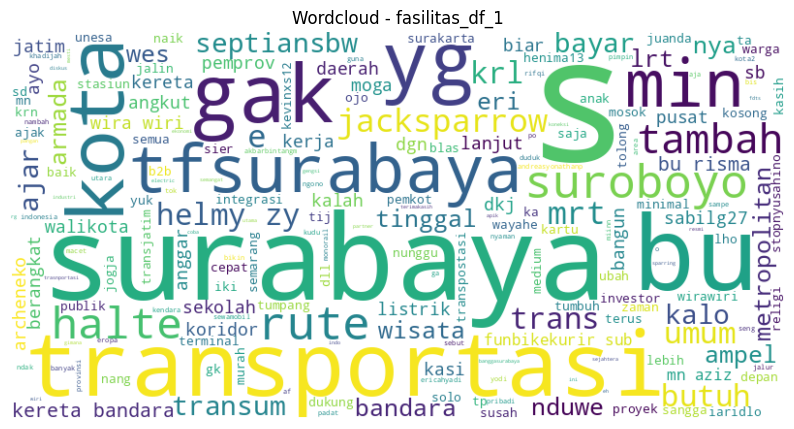

In [ ]:
fasilitas_df_1_processed.to_excel('fasilitas_df_1_processed.xlsx', index=False)
visualisasi_data(fasilitas_df_1_processed, 'fasilitas_df_1')

Hasil visualisasi dari bar chart dan pie chart menunjukan bahwa 73% komentar bersentimen netral, yang artinya bahwa fasilitas yang diberikan pemerintah cenderung biasa saja, banyak warga masyarakat yang antara setuju dan tidak setuju dengan fasilitas yang disediakan, disamping itu, sentimen negatif memiliki proporsi yang lebih banyak dibandingkan dengan proporsi sentimen negatif.


Lalu, dari hasil wordcloud, kata yang paling sering muncul adalah surabaya yang merupakan kota yang diambil sebagai subjek penelitian, lalu beberapa kata seperti transportasi, kota, mrt, transum, halte, dan lainnya yang menandakan topik yang sedang dibahas adalah transportas umum.

### **Aspek Fasilitas 2**

In [ ]:
# Memproses data fasilitas_df_2
print("=== Memproses Data: fasilitas_df_2 ===")
fasilitas_df_2_processed = preprocessing_data(fasilitas_df_2)
fasilitas_df_2_processed

=== Memproses Data: fasilitas_df_2 ===


,Username,Waktu,Komentar,cleaned_comment,tokens,filtered_tokens,lemmatized_comment,sentiment_raw,sentiment
0,owenlantu,11w,Semoga semakin lengkap lagi yg ada didalam mus...,Semoga semakin lengkap lagi yg ada didalam mus...,"[semoga, semakin, lengkap, lagi, yg, ada, dida...","[semoga, lengkap, yg, didalam, museum, surabay...",moga lengkap yg dalam museum surabaya siola po...,LABEL_0,positive
1,mirnatiaralestari,11w,Tiket Masuk nya brp min? fisioterapisurabaya's,Tiket Masuk nya brp min? fisioterapisurabaya's,"[tiket, masuk, nya, brp, min?, fisioterapisura...","[tiket, masuk, nya, brp, min?, fisioterapisura...",tiket masuk nya brp min fisioterapisurabaya s,LABEL_1,neutral
2,fisioterapisurabaya,11w,"Wuah, kereen! ð¤© henima13's","Wuah, kereen! ð¤© henima13's","[wuah,, kereen!, ð¤©, henima13's]","[wuah,, kereen!, ð¤©, henima13's]",wuah kereen henima13 s,LABEL_0,positive
3,henima13,11w,"SURABAYA PUNYA MALL BARU DI SURABAYA TIMUR, PC...","SURABAYA PUNYA MALL BARU DI SURABAYA TIMUR, PC...","[surabaya, punya, mall, baru, di, surabaya, ti...","[surabaya, mall, surabaya, timur,, pcm, 3, !, ...",surabaya mall surabaya timur pcm 3 surabaya k...,LABEL_0,positive
5,jacksparrow_is_me,11w,Memang jos bu Risma kerjanya. Kerja sesuai tar...,Memang jos bu Risma kerjanya. Kerja sesuai tar...,"[memang, jos, bu, risma, kerjanya., kerja, ses...","[jos, bu, risma, kerjanya., kerja, sesuai, tar...",jos bu risma kerja kerja sesuai target 100 ker...,LABEL_0,positive


Dataframe di atas, menunjukan hasil preprocessing teks hingga klasifikasi sentimen yang diperlukan, mulai dari tahapan cleaning lemmitization teks dan diakhiri dengan klasifikasi sentimen dari setiap komentarnya. Komentar beragam bermunculan pada aspek fasilitas ini, mulai dari komentar yang memberikan saran, dan apresiasi terhadap fasilitas.

Tabel Distribusi Sentimen - fasilitas_df_2
   Sentimen  Jumlah
0  positive       4
1   neutral       1




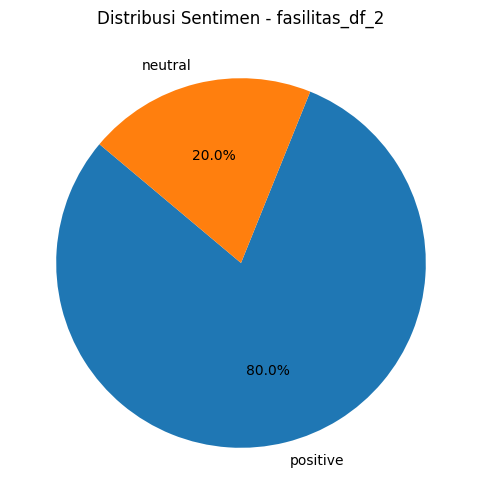

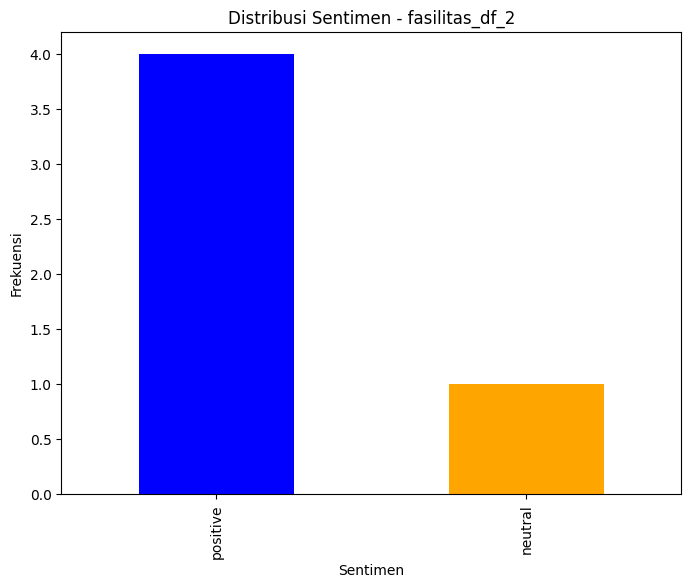

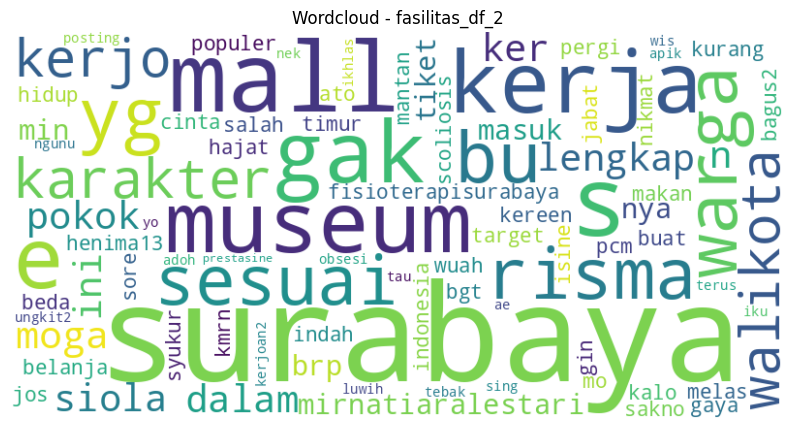

In [ ]:
fasilitas_df_2_processed.to_excel('fasilitas_df_2_processed.xlsx', index=False)
visualisasi_data(fasilitas_df_2_processed, 'fasilitas_df_2')


Hasil visualisasi dari bar chart dan pie chart menunjukan bahwa 80% komentar bersentimen positif yang menandakan bahwa fasilitas tersebut sangatlah digemari oleh masyarakat. Lalu, sentimen netral atau sisanya hanya 20%.


Lalu, dari hasil wordcloud, kata yang paling sering muncul adalah surabaya yang merupakan kota yang diambil sebagai subjek penelitian, lalu beberapa kata seperti museum, mall, kerja, karakter, risma yang menandakan fasilitas umum yang sedang dibahas pada postingan instagram tersebut.

### **Aspek Layanan 1**

In [ ]:
# Memproses data layanan_df_1
print("=== Memproses Data: layanan_df_1 ===")
layanan_df_1_processed = preprocessing_data(layanan_df_1)
layanan_df_1_processed

=== Memproses Data: layanan_df_1 ===


,Username,Waktu,Komentar,cleaned_comment,tokens,filtered_tokens,lemmatized_comment,sentiment_raw,sentiment
0,surabaya,18w,Uda Kenal Belum Sama R1N1 ? R1N1 adalah Pelay...,Uda Kenal Belum Sama R1N1 ? R1N1 adalah Pelay...,"[uda, kenal, belum, sama, r1n1, ?, r1n1, adala...","[uda, kenal, r1n1, ?, r1n1, pelayanan, kesehat...",uda kenal r1n1 r1n1 layan sehat warga surabay...,LABEL_0,positive
1,f_nthul,18w,Bisa periksa gigi anak2 ga kalo ke R1N1 ??? bi...,Bisa periksa gigi anak2 ga kalo ke R1N1 ??? bi...,"[bisa, periksa, gigi, anak2, ga, kalo, ke, r1n...","[periksa, gigi, anak2, ga, kalo, r1n1, ???, bi...",periksa gigi anak2 ga kalo r1n1 bilqizuhri s,LABEL_1,neutral
2,bilqizuhri,18w,Dpt kotakan ya. Daerahku gak dpt😂,Dpt kotakan ya. Daerahku gak dpt😂,"[dpt, kotakan, ya., daerahku, gak, dpt😂]","[dpt, kotakan, ya., daerahku, gak, dpt😂]",dpt kota ya daerah gak dpt,LABEL_1,neutral
3,umamahfathiyah,18w,Bisa cek darah disitu kak? krisnaagungmurti's,Bisa cek darah disitu kak? krisnaagungmurti's,"[bisa, cek, darah, disitu, kak?, krisnaagungmu...","[cek, darah, disitu, kak?, krisnaagungmurti's]",cek darah situ kak krisnaagungmurti s,LABEL_1,neutral
4,krisnaagungmurti,18w,Lek 1R1N kyk e luweh pas. 1 RW 1 Nakes datayul...,Lek 1R1N kyk e luweh pas. 1 RW 1 Nakes datayul...,"[lek, 1r1n, kyk, e, luweh, pas., 1, rw, 1, nak...","[lek, 1r1n, kyk, e, luweh, pas., 1, rw, 1, nak...",lek 1r1n kyk e luweh pas 1 rw 1 nakes datayuli s,LABEL_1,neutral
5,datayuli,18w,@krisnaagungmurti 🤭🤭🤭 nefertitie2014's,@krisnaagungmurti 🤭🤭🤭 nefertitie2014's,"[@krisnaagungmurti, 🤭🤭🤭, nefertitie2014's]","[@krisnaagungmurti, 🤭🤭🤭, nefertitie2014's]",krisnaagungmurti nefertitie2014 s,LABEL_1,neutral
6,nefertitie2014,18w,Hebat Surabaya😍 amel_camelia123's,Hebat Surabaya😍 amel_camelia123's,"[hebat, surabaya😍, amel_camelia123's]","[hebat, surabaya😍, amel_camelia123's]",hebat surabaya amel camelia123 s,LABEL_0,positive
7,amel_camelia123,18w,Ben Podo Karo jenenge Bu walkot nuzilarf's,Ben Podo Karo jenenge Bu walkot nuzilarf's,"[ben, podo, karo, jenenge, bu, walkot, nuzilar...","[ben, podo, karo, jenenge, bu, walkot, nuzilar...",ben podo karo jenenge bu walkot nuzilarf s,LABEL_2,negative
8,nuzilarf,18w,Masalahnya kesadaran warganya yg kurang akan k...,Masalahnya kesadaran warganya yg kurang akan k...,"[masalahnya, kesadaran, warganya, yg, kurang, ...","[kesadaran, warganya, yg, kesehatan,, minim, w...",sadar warga yg sehat minim warga yg dtg layan ...,LABEL_1,neutral
9,winterrrr111,18w,@nuzilarf lebih ke jika ada kegiatan khusus Bu...,@nuzilarf lebih ke jika ada kegiatan khusus Bu...,"[@nuzilarf, lebih, ke, jika, ada, kegiatan, kh...","[@nuzilarf, kegiatan, khusus, bu, adanya,, aca...",nuzilarf giat khusus bu ada acara lansia scoli...,LABEL_1,neutral


Dataframe di atas, menunjukan hasil preprocessing teks hingga klasifikasi sentimen yang diperlukan, mulai dari tahapan cleaning lemmitization teks dan diakhiri dengan klasifikasi sentimen dari setiap komentarnya. Komentar beragam bermunculan pada aspek layanan ini, seperti antusias masyarakat terhadap layanan tersebut, lalu menanyakan apakah layanan jenis tertentu bisa dilakukan atau tidak

Tabel Distribusi Sentimen - layanan_df_1
   Sentimen  Jumlah
0   neutral      18
1  positive       2
2  negative       1




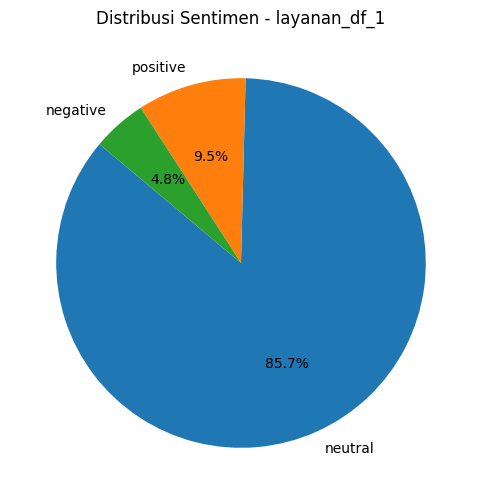

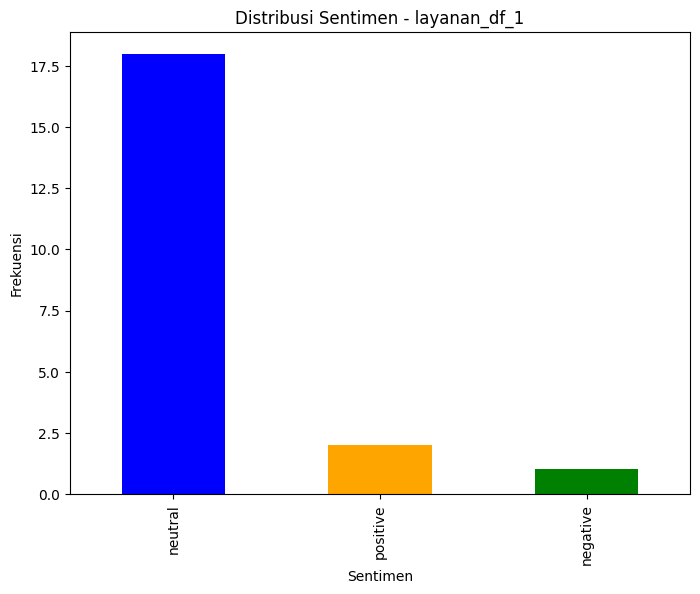

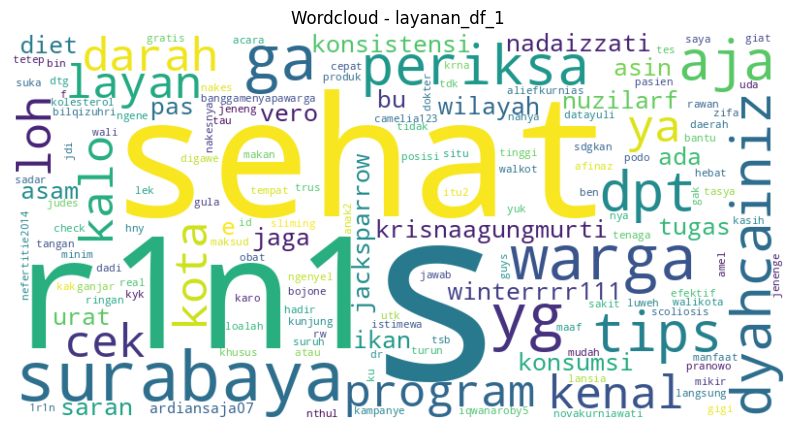

In [ ]:
layanan_df_1_processed.to_excel('layanan_df_1_processed.xlsx', index=False)
visualisasi_data(layanan_df_1_processed, 'layanan_df_1')

Hasil visualisasi dari bar chart dan pie chart menunjukan bahwa proporsi sentimen yang paling banyak adalah sentimen netral dengan proporsi sebanyak 85.7% yang menandakan bahwa masyarakat cenderung bersikap biasa saja terhadap layanan ini. Lalu sebanyak 9.5% sentimen positif dan sisanya negatif.


Lalu, dari hasil wordcloud, kata yang paling sering muncul berkaitan dengan berbagai macam pelayanan seperti sehat, program, layan, periksa, yang menandakan mengenai layanan kesehatan di Surabaya.

### **Aspek Layanan 2**

In [ ]:
# Memproses data layanan_df_2
print("=== Memproses Data: layanan_df_2 ===")
layanan_df_2_processed = preprocessing_data(layanan_df_2)
layanan_df_2_processed

=== Memproses Data: layanan_df_2 ===


,Username,Waktu,Komentar,cleaned_comment,tokens,filtered_tokens,lemmatized_comment,sentiment_raw,sentiment
0,Anonymous,9w,daya mau buat akte lahir bisa ya,daya mau buat akte lahir bisa ya,"[daya, mau, buat, akte, lahir, bisa, ya]","[daya, akte, lahir, ya]",daya akte lahir ya,LABEL_1,neutral
3,Anonymous,13w,Lengkap satu atap ❤️🔥,Lengkap satu atap ❤️🔥,"[lengkap, satu, atap, ❤️🔥]","[lengkap, atap, ❤️🔥]",lengkap atap,LABEL_0,positive
6,Anonymous,13w,Yok ke siola yok😍😍😍,Yok ke siola yok😍😍😍,"[yok, ke, siola, yok😍😍😍]","[yok, siola, yok😍😍😍]",yok siola yok,LABEL_1,neutral
8,Anonymous,13w,"Naah, ngono lih, Min... Iki sampeyan setel nan...","Naah, ngono lih, Min... Iki sampeyan setel nan...","[naah,, ngono, lih,, min..., iki, sampeyan, se...","[naah,, ngono, lih,, min..., iki, sampeyan, se...",naah ngono lih min iki sampeyan setel nang nga...,LABEL_2,negative
10,Anonymous,13w,Perpanjangan SIM juga bisa disini kah ?,Perpanjangan SIM juga bisa disini kah ?,"[perpanjangan, sim, juga, bisa, disini, kah, ?]","[perpanjangan, sim, kah, ?]",panjang sim kah,LABEL_2,negative
11,septinchristanti,13w,untuk perpanjangan SIM bisa dilakukan di Mall ...,untuk perpanjangan SIM bisa dilakukan di Mall ...,"[untuk, perpanjangan, sim, bisa, dilakukan, di...","[perpanjangan, sim, mall, pelayanan, publik, s...",panjang sim mall layan publik surabaya,LABEL_1,neutral
12,dpmptspsby,13w,berarti di siola bisa ya,berarti di siola bisa ya,"[berarti, di, siola, bisa, ya]","[siola, ya]",siola ya,LABEL_0,positive
13,Anonymous,13w,Mbois rekkk 🔥🔥🔥,Mbois rekkk 🔥🔥🔥,"[mbois, rekkk, 🔥🔥🔥]","[mbois, rekkk, 🔥🔥🔥]",mbois rekkk,LABEL_2,negative


Dataframe di atas, menunjukan hasil preprocessing teks hingga klasifikasi sentimen yang diperlukan, mulai dari tahapan cleaning lemmitization teks dan diakhiri dengan klasifikasi sentimen dari setiap komentarnya. Komentar beragam bermunculan pada aspek layanan ini, seperti antusias masyarakat terhadap layanan tersebut, lalu menanyakan apakah layanan jenis tertentu bisa dilakukan atau tidak

Tabel Distribusi Sentimen - layanan_df_2
   Sentimen  Jumlah
0   neutral       3
1  negative       3
2  positive       2




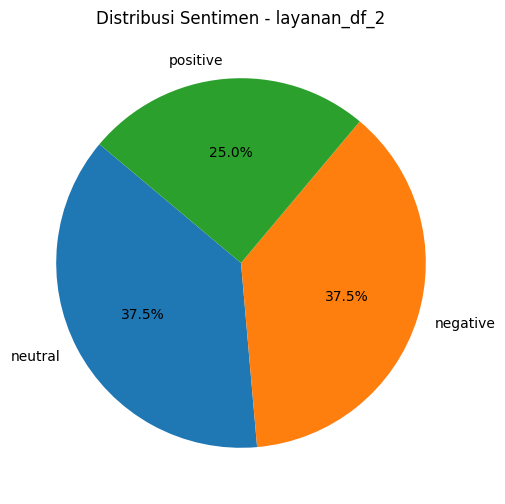

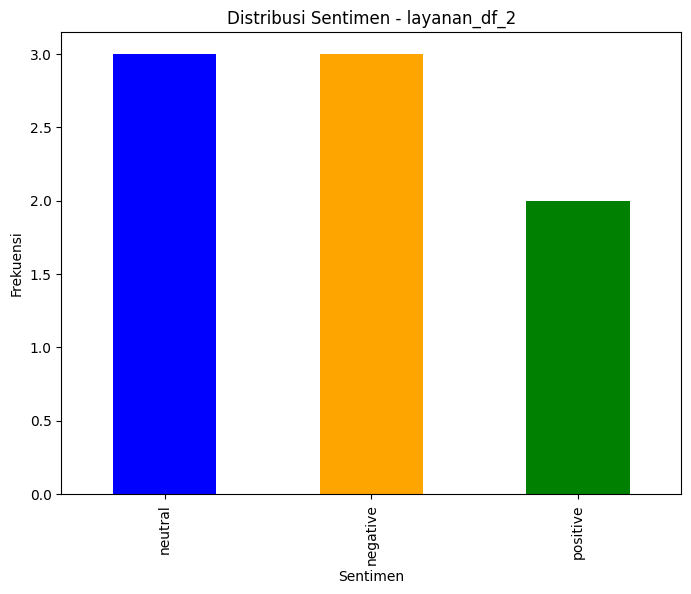

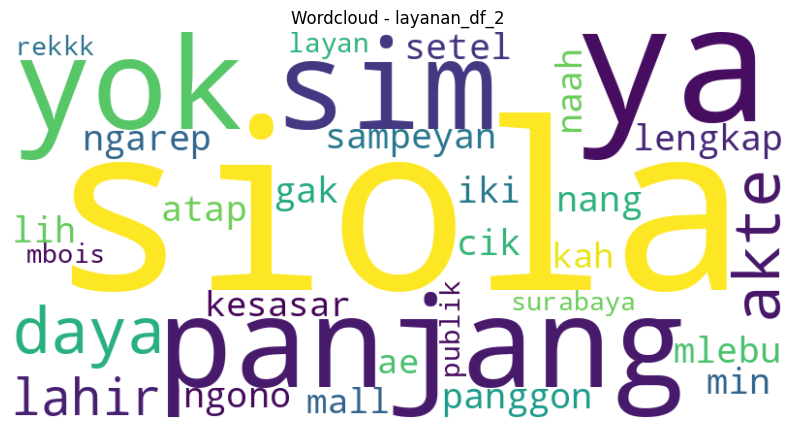

In [ ]:
layanan_df_2_processed.to_excel('layanan_df_2_processed.xlsx', index=False)
visualisasi_data(layanan_df_2_processed, 'layanan_df_2')

Hasil visualisasi dari bar chart dan pie chart menunjukan bahwa proporsi antara sentimen positif, negatif, dan netral cenderung sama. Namun, lebih banyak pada sentimen netral dan negatif.


Lalu, dari hasil wordcloud, kata yang paling sering muncul berkaitan dengan berbagai macam pelayanan seperti sim, panjang, siola, daya, dan lainnya.

### **Aspek Program 1**

In [ ]:
# Memproses data program_df_1
print("=== Memproses Data: program_df_1 ===")
program_df_1_processed = preprocessing_data(program_df_1)
program_df_1_processed

=== Memproses Data: program_df_1 ===


,Username,Waktu,Komentar,cleaned_comment,tokens,filtered_tokens,lemmatized_comment,sentiment_raw,sentiment
0,Anonymous,132w,Situs 502 getway,Situs 502 getway,"[situs, 502, getway]","[situs, 502, getway]",situs 502 getway,LABEL_1,neutral
1,Anonymous,132w,Aplikasi web asik ini apakah bisa memantau set...,Aplikasi web asik ini apakah bisa memantau set...,"[aplikasi, web, asik, ini, apakah, bisa, meman...","[aplikasi, web, asik, memantau, harinya, lowon...",aplikasi web asik pantau hari lowong kerja lua...,LABEL_1,neutral
2,Anonymous,132w,Boleh di klik juga di bio profile kita untuk l...,Boleh di klik juga di bio profile kita untuk l...,"[boleh, di, klik, juga, di, bio, profile, kita...","[klik, bio, profile, lowongan, kerja, terbaru,...",klik bio profile lowong kerja baru ya tinggal ...,LABEL_1,neutral
3,Anonymous,132w,Wahh keren ??,Wahh keren ??,"[wahh, keren, ??]","[wahh, keren, ??]",wahh keren,LABEL_0,positive
5,Anonymous,132w,"Mohon maaf, aku mau numpang nanya, kira2 disin...","Mohon maaf, aku mau numpang nanya, kira2 disin...","[mohon, maaf,, aku, mau, numpang, nanya,, kira...","[mohon, maaf,, numpang, nanya,, kira2, yg, tau...",mohon maaf numpang nanya kira2 yg tau ngilangi...,LABEL_1,neutral
6,Anonymous,132w,@riskaanjani392 Coba pake produk dari @eyelift...,@riskaanjani392 Coba pake produk dari @eyelift...,"[@riskaanjani392, coba, pake, produk, dari, @e...","[@riskaanjani392, coba, pake, produk, @eyelift...",riskaanjani392 coba pake produk eyelifttreatme...,LABEL_0,positive
7,Anonymous,132w,@annisa19935 Aman ga nih produknya?? Takut ada...,@annisa19935 Aman ga nih produknya?? Takut ada...,"[@annisa19935, aman, ga, nih, produknya??, tak...","[@annisa19935, aman, ga, nih, produknya??, tak...",annisa19935 aman ga nih produk takut efek samp...,LABEL_1,neutral
8,Anonymous,132w,@riskaanjani392 Amann kakk tenang ajaa. Soalny...,@riskaanjani392 Amann kakk tenang ajaa. Soalny...,"[@riskaanjani392, amann, kakk, tenang, ajaa., ...","[@riskaanjani392, amann, kakk, tenang, ajaa., ...",riskaanjani392 amann kakk tenang ajaa produk u...,LABEL_1,neutral


Dataframe di atas, menunjukan hasil preprocessing teks hingga klasifikasi sentimen yang diperlukan, mulai dari tahapan cleaning lemmitization teks dan diakhiri dengan klasifikasi sentimen dari setiap komentarnya. Komentar beragam bermunculan pada aspek program ini, mulai dari masyarakat yang antusias mengenai program ini hingga berbagai macam dukungan terhadap program ini.

Tabel Distribusi Sentimen - program_df_1
   Sentimen  Jumlah
0   neutral       6
1  positive       2




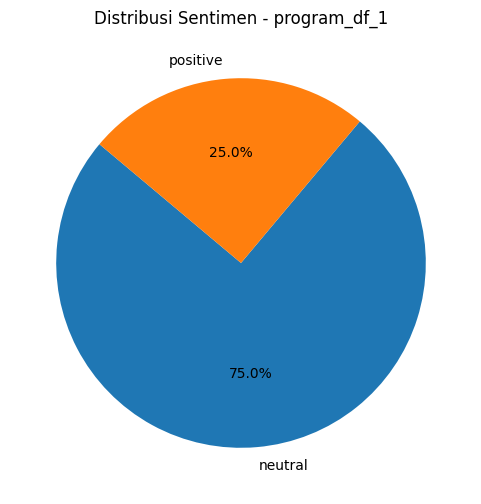

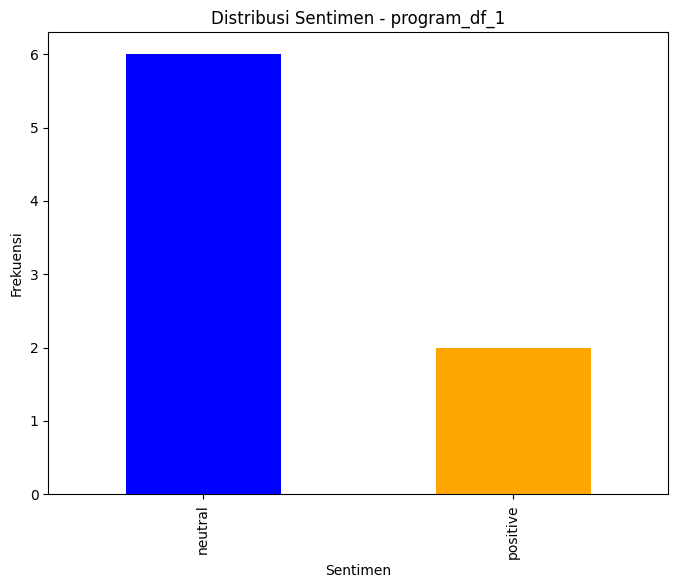

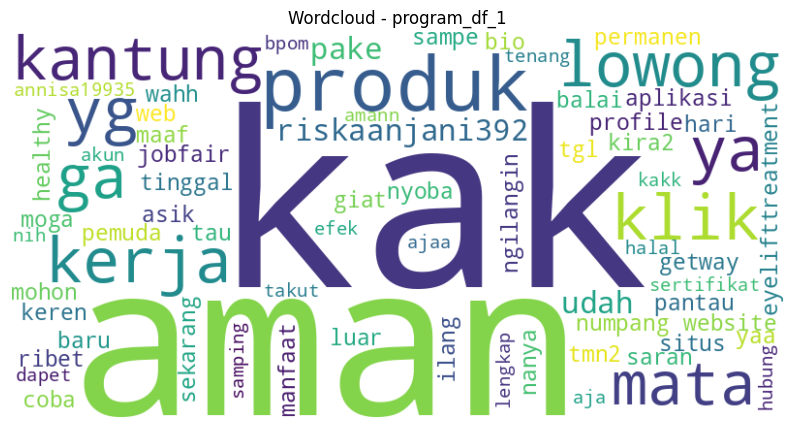

In [ ]:
program_df_1_processed.to_excel('program_df_1_processed.xlsx', index=False)
visualisasi_data(program_df_1_processed, 'program_df_1')

Hasil visualisasi dari bar chart dan pie chart menunjukan bahwa 75% bersentimen netral, dan sisanya potifif. Hal ini menunjukan bahwa program ini yang dilakukan oleh pemerintah dapat diterima masyarakat dengan baik.

Lalu, dari hasil wordcloud, kata yang paling sering muncul adalah yang berkaitan dengan program seperti kantung, produk, kerja, lowong yang kemungkinan membahasa mengenai lowongan pekerjaan.

### **Aspek Program 2**

In [ ]:
# Memproses data program_df_2
print("=== Memproses Data: program_df_2 ===")
program_df_2_processed = preprocessing_data(program_df_2)
program_df_2_processed

=== Memproses Data: program_df_2 ===


,Username,Waktu,Komentar,cleaned_comment,tokens,filtered_tokens,lemmatized_comment,sentiment_raw,sentiment
0,ericahyadi_,18w,Perbaikan Rumah Tidak Layak Huni (Rutilahu) te...,Perbaikan Rumah Tidak Layak Huni (Rutilahu) te...,"[perbaikan, rumah, tidak, layak, huni, (rutila...","[perbaikan, rumah, layak, huni, (rutilahu), di...",baik rumah layak huni rutilahu kebut kewat pro...,LABEL_1,neutral
1,shermansyah172,18w,Jalan Pakis 32 Cak butuh di bantu renov rumah ...,Jalan Pakis 32 Cak butuh di bantu renov rumah ...,"[jalan, pakis, 32, cak, butuh, di, bantu, reno...","[jalan, pakis, 32, cak, butuh, bantu, renov, r...",jalan pakis 32 cak butuh bantu renov rumah bu ...,LABEL_1,neutral
2,atnifauziah,17w,"Rumahku juga atap ya bolong"" pak mohon bantuan...","Rumahku juga atap ya bolong"" pak mohon bantuan...","[rumahku, juga, atap, ya, bolong"", pak, mohon,...","[rumahku, atap, ya, bolong"", mohon, bantuannya...",rumah atap ya bolong mohon bantu qomarsby s,LABEL_1,neutral
3,qomarsby,18w,Pengaspalan jalan sepanjang jalan jagir sampai...,Pengaspalan jalan sepanjang jalan jagir sampai...,"[pengaspalan, jalan, sepanjang, jalan, jagir, ...","[pengaspalan, jalan, jalan, jagir, nginden, it...",aspal jalan jalan jagir nginden ita lusiana8701 s,LABEL_1,neutral
4,ita_lusiana8701,18w,Mohon maaf bapak di wilayah saya jg ada seoran...,Mohon maaf bapak di wilayah saya jg ada seoran...,"[mohon, maaf, bapak, di, wilayah, saya, jg, ad...","[mohon, maaf, wilayah, jg, janda, yg, atapnya,...",mohon maaf wilayah jg janda yg atap roboh maka...,LABEL_2,negative
5,minimarket,17w,mantab ðð ana_kohes's,mantab ðð ana_kohes's,"[mantab, ðð, ana_kohes's]","[mantab, ðð, ana_kohes's]",mantab ana kohes s,LABEL_0,positive
6,ana_kohes,17w,gmn carane daftar pak..mohon dikasih tau shizu...,gmn carane daftar pak..mohon dikasih tau shizu...,"[gmn, carane, daftar, pak..mohon, dikasih, tau...","[gmn, carane, daftar, pak..mohon, dikasih, tau...",gmn carane daftar pak mohon kasih tau shizuca ...,LABEL_1,neutral
7,shizuca_parfumery,18w,Gimana caranya daftarnya... shermansyah172's,Gimana caranya daftarnya... shermansyah172's,"[gimana, caranya, daftarnya..., shermansyah172's]","[gimana, daftarnya..., shermansyah172's]",gimana daftar shermansyah172 s,LABEL_1,neutral
8,shermansyah172,18w,Rumah burung Dara di pemukiman aapa boleh ya d...,Rumah burung Dara di pemukiman aapa boleh ya d...,"[rumah, burung, dara, di, pemukiman, aapa, bol...","[rumah, burung, dara, pemukiman, aapa, ya, gen...",rumah burung dara mukim aapa ya genteng mukim ...,LABEL_1,neutral
9,jasasaluranmampetsurabaya,18w,Mantapp ð juli.kristantoniko2020's juli.,Mantapp ð juli.kristantoniko2020's juli.,"[mantapp, ð, juli.kristantoniko2020's, juli.]","[mantapp, ð, juli.kristantoniko2020's, juli.]",mantapp juli kristantoniko2020 s juli,LABEL_0,positive


Dataframe di atas, menunjukan hasil preprocessing teks hingga klasifikasi sentimen yang diperlukan, mulai dari tahapan cleaning lemmitization teks dan diakhiri dengan klasifikasi sentimen dari setiap komentarnya. Komentar beragam bermunculan pada aspek program ini, seperti mengeluhkan keadaan rumah, kritik terhadap program, dan lainnya

Tabel Distribusi Sentimen - program_df_2
   Sentimen  Jumlah
0   neutral      43
1  positive       9
2  negative       8




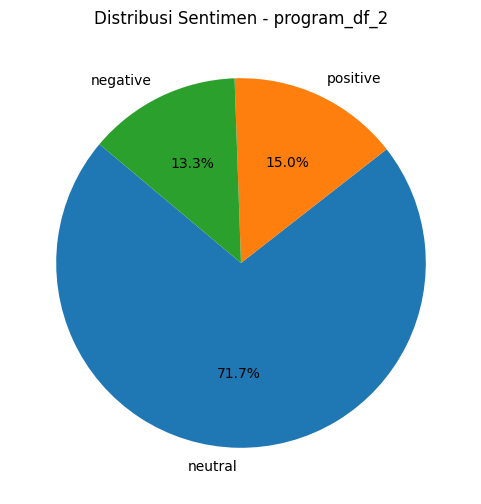

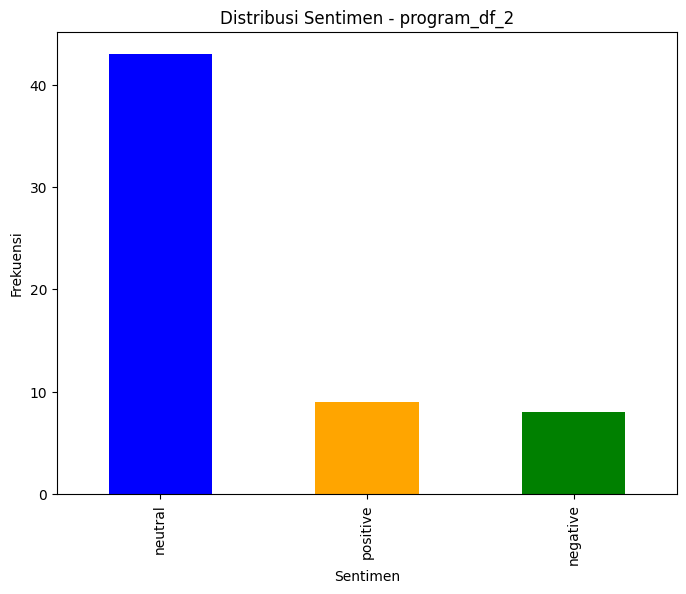

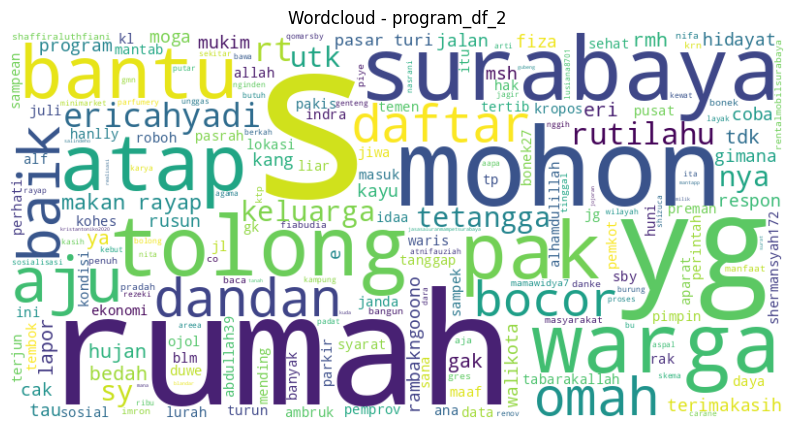

In [ ]:
program_df_2_processed.to_excel('program_df_2_processed.xlsx', index=False)
visualisasi_data(program_df_2_processed, 'program_df_2')

Hasil visualisasi dari bar chart dan pie chart menunjukan bahwa 71% komentar bersentimen netral, yang artinya bahwa program yang dilaksanakan pemerintah cenderung biasa saja, banyak warga masyarakat yang antara setuju dan tidak setuju dengan program yang disediakan, disamping itu, sentimen positif memiliki proporsi yang lebih banyak dibandingkan dengan proporsi sentimen negatif.


Lalu, dari hasil wordcloud, kata yang paling sering muncul adalah rumah, bocor, atap, surabaya, dan lainnya. Hal ini menunjukan bahwa masyarakat melakukan curhat terhadap pemerintah mengenai keadaan rumahnya.